In [5]:
%load_ext autoreload
%autoreload 2

import os
from tqdm.notebook import tqdm
from imaris_ims_file_reader.ims import ims
import dask.array as da
import pandas as pd
import numpy as np
import pickle as pkl
import napari
from cellpose import models
from skimage.io import imread,imsave
import seaborn as sns
import matplotlib.pyplot as plt

from sem_quant.processing_utils import extract_regionprops, find_edge_df, mask_from_df, suppress_by_iou, compute_iou_array, add_soma_data, mark_tile_edge_objects
from sem_quant.load_config import load_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Setup

In [6]:
config_file_name = "A01_config.json"

In [7]:
# read in config file

config = load_config(config_file_name)

im_path = config.paths.im_path
analysis_dir = config.paths.analysis_dir

output_prefix = config.paths.output_prefix
axons_data_suffix = config.paths.axons_data_suffix

axons_res = config.data_properties.axons_res
px_size = config.data_properties.px_size

## Get an image

In [8]:
store = imread(im_path, aszarr=True)
im = da.from_zarr(store, axons_res)
im_shape = im.shape

C:\Users\KMK280\AppData\Local\Temp\ipykernel_43928\647131095.py:1: FutureWarning: The plugin infrastructure in `skimage.io` is deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not pass additional keyword arguments for plugins (`**plugin_args`). Instead, use `imageio` or other I/O packages directly. See also `skimage.io.imread`.
  store = imread(im_path, aszarr=True)


In [9]:
viewer = napari.Viewer()
viewer.add_image(im)

<Image layer 'im' at 0x293d646d990>

## Clean SAM masks

In [11]:
properties = ['area', 'area_convex', 'area_filled', 'euler_number', 'image','bbox',
        'eccentricity', 'solidity', 'centroid', 'major_axis_length', 'minor_axis_length']


file_list = [x for x in os.listdir(os.path.join(analysis_dir,'axons')) if x.startswith('tile_masks') and x.endswith('.pkl')]

df_all_list = []
for file_name in tqdm(file_list):

    print(f'Processing {file_name}')    

    df_path = os.path.join(analysis_dir,'axons',file_name)
    df = pd.read_pickle(df_path)
    print(f'Loaded {len(df)} masks.')

    # divide masks into separate objects
    props_list = [] 
    for ind, row in df.iterrows():
        props = extract_regionprops(row,properties,small_size=50)
        # keep origin of the data
        props['origin'] = ind
        props_list.append(props)

    props_all = pd.concat(props_list, ignore_index=True)
    props_all.columns = [ f'sc_{col}' if col == 'area' else col for col in props_all.columns]

    # drop the segmentation column
    df.drop(columns=['segmentation'], inplace=True)

    # Concatenate with the original DataFrame
    df['origin'] = df.index
    df_all = pd.merge(df, props_all,left_on = 'origin', right_on= 'origin', how = 'right').reset_index()

    df_all['label'] = df_all.index + 1

    print(f'Kept {len(df_all)} axons.')

    df_all_list.append(df_all)

  0%|          | 0/24 [00:00<?, ?it/s]

Processing tile_masks_00000_00000.pkl
Loaded 568 masks.
Kept 595 axons.
Processing tile_masks_00000_00724.pkl
Loaded 562 masks.
Kept 580 axons.
Processing tile_masks_00000_01448.pkl
Loaded 533 masks.
Kept 557 axons.
Processing tile_masks_00000_02172.pkl
Loaded 613 masks.
Kept 635 axons.
Processing tile_masks_00000_02896.pkl
Loaded 461 masks.
Kept 474 axons.
Processing tile_masks_00000_02986.pkl
Loaded 435 masks.
Kept 447 axons.
Processing tile_masks_00724_00000.pkl
Loaded 539 masks.
Kept 552 axons.
Processing tile_masks_00724_00724.pkl
Loaded 544 masks.
Kept 556 axons.
Processing tile_masks_00724_01448.pkl
Loaded 465 masks.
Kept 488 axons.
Processing tile_masks_00724_02172.pkl
Loaded 464 masks.
Kept 485 axons.
Processing tile_masks_00724_02896.pkl
Loaded 481 masks.
Kept 497 axons.
Processing tile_masks_00724_02986.pkl
Loaded 487 masks.
Kept 510 axons.
Processing tile_masks_01448_00000.pkl
Loaded 525 masks.
Kept 543 axons.
Processing tile_masks_01448_00724.pkl
Loaded 522 masks.
Kept 535

## Remove objects touching internal borders of the tiles

In [ ]:
df = pd.concat(df_all_list, ignore_index=True)
df.label = df.index + 1
print(f'Starting number of axons: {len(df)}')

# move into the full image coordinate system
df['bbox-0'] = df['bbox-0'] + df['tile_row_start']
df['bbox-1'] = df['bbox-1'] + df['tile_col_start']
df['bbox-2'] = df['bbox-2'] + df['tile_row_start']
df['bbox-3'] = df['bbox-3'] + df['tile_col_start']
df['centroid-0'] = df['centroid-0'] + df['tile_row_start']
df['centroid-1'] = df['centroid-1'] + df['tile_col_start']

# remove not promissing objects based on updated parameters
df = df.loc[((df['euler_number'] < 1) & (df.sc_area/df.area_filled < config.axons_filters.max_solidity)),:]

# remove edge objects of internal tile boundaries
df = mark_tile_edge_objects(df, pad=5, filter='not_edge')
print(f'Number of axons after removing edge objects: {len(df)}')
df['edge_ring'] = False

## Suppress overlapping objects

In [ ]:
# supress by iou
df = df.reset_index(drop=True)
df_res = suppress_by_iou(df, iou_threshold=0.2)
df_res = df_res.loc[df_res.keep == 1,:]
print(f'Number of axons after suppressing overlaping objects: {len(df_res)}')

Starting number of axons: 12705
Number of axons after removing edge objects: 3362
Number of axons after suppressing overlaping objects: 1308


<Axes: xlabel='sc_area', ylabel='Count'>

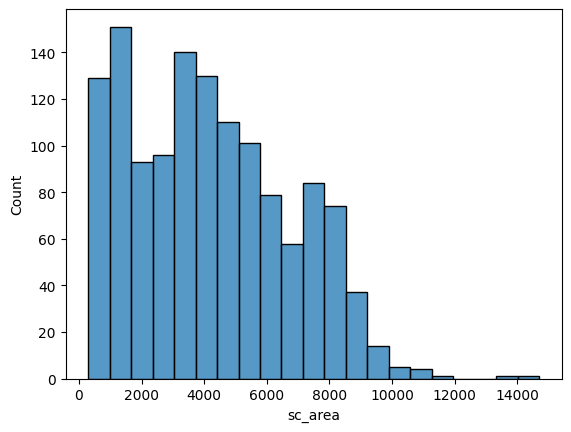

In [13]:
sns.histplot(df_res['sc_area'])

## Find axons soma

In [14]:
inside_props = ['area', 'eccentricity', 'major_axis_length', 'minor_axis_length', 'centroid', 'bbox','image']
pad = 3

df_final = add_soma_data(df_res, inside_props, pad = pad)

# clean up labels
df_final = df_final.reset_index(drop=True)
df_final['label'] = df_final.index + 1
df_final['inside_label'] = df_final.index + 1


## Visualize cleaned masks

In [15]:
# Visualize myelin rings

mask = mask_from_df(df_final,im_shape, prefix='')
viewer.add_labels(mask, name='myelin rings', opacity = 0.8)#, scale = scale)

# Visualize detected axons

mask = mask_from_df(df_final, im_shape, prefix='inside_')
viewer.add_labels(mask, name='axons', opacity = 0.4)#, scale = scale)

<Labels layer 'axons' at 0x29400719290>

## Save data frame

In [16]:
df_name = f'{output_prefix}axons.pkl'
df_final.to_pickle(os.path.join(analysis_dir,df_name))